
#### Dr.Varodom Toochinda
<p />Dept.of Mechanical ENgineering, Kasetsart University

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In this notebook, we learn about how to smoothen a signal using averaging techniques.

Let's create a function to synthesize some 140 samples of contaminated signal. 

In [2]:
def gen_data():
    t_vec = np.arange(-0.7,0.7,0.01)
    t_vec = t_vec[:,np.newaxis]
    numpts = t_vec.shape[0]
    y_vec = 1.5*t_vec**3 - t_vec + 0.7/(3 + 40*t_vec**2) + 0.3*np.random.rand(numpts,1)
    k_vec = np.arange(0,numpts)
    k_vec = k_vec[:,np.newaxis]
    return k_vec, y_vec

In [3]:
k_vec, y_vec = gen_data()

In [4]:
k_vec.shape

(140, 1)

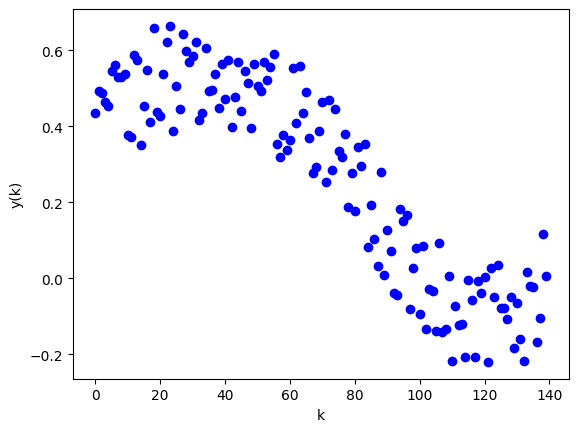

In [5]:
plt.figure()
plt.plot(k_vec,y_vec,'bo')
plt.xlabel("k")
plt.ylabel("y(k)")
plt.show()

### n-point moving average

A simple approach is to use a moving average filter (MAF). Write a function to implement 
an n-point MAF and plot the resulting vector.

In [15]:
def maf(y, n=4):
    y_size = y.shape[0]  # find original vector size
    v = np.zeros((y_size,1))
    v[0:n,0] = y[0:n,0]  # just copy data points prior to the point where MAF starts. Optional
    for k in range(n,y_size):
        v[k,0] = np.mean(y[k-n:k,0])
    return v



In [18]:
v_maf4 = maf(y_vec)
v_maf8 = maf(y_vec, n=8)
v_maf12 = maf(y_vec, n=12)

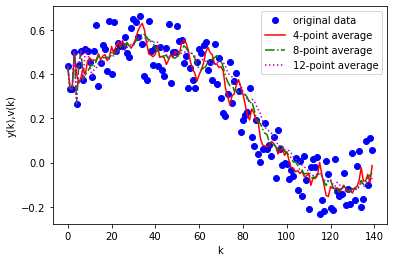

In [19]:
plt.figure()
plt.plot(k_vec,y_vec,'bo',k_vec,v_maf4,'r-',k_vec,v_maf8,'g-.',k_vec,v_maf12,'m:')
plt.xlabel("k")
plt.ylabel("y(k),v(k)")
plt.legend(["original data","4-point average","8-point average","12-point average"])
plt.show()

We see that MAF does a good job to smooth out the noise. The drawback is the computation 
is expensive and slow when implemented on an MCU, especially when averaging over 
several data points.

**Aside :** In a real-time application, we do not have all the data available before applying MAF. So it must be applied at an input of MCU to receive instantenous sample. A circular structure may be used to implement an MAF efficeintly. Think about this, then try to code one below.

**Hint :** See problem (4.18) on page 218 of my Thai book *py4conemb*.

In [18]:
# real-time moving average filter
n = 4  
maf_y = np.zeros((n,))
maf_sum = 0
maf_i = 0
def rt_maf(y_in):
    global maf_y, maf_sum, maf_i
    maf_sum -= maf_y[maf_i]
    maf_y[maf_i] = y_in
    maf_sum += maf_y[maf_i]
    maf_avg = maf_sum/n
    maf_i += 1
    if maf_i==n: 
        maf_i = 0
    return maf_avg


Run this cell to test your real-time MAF.

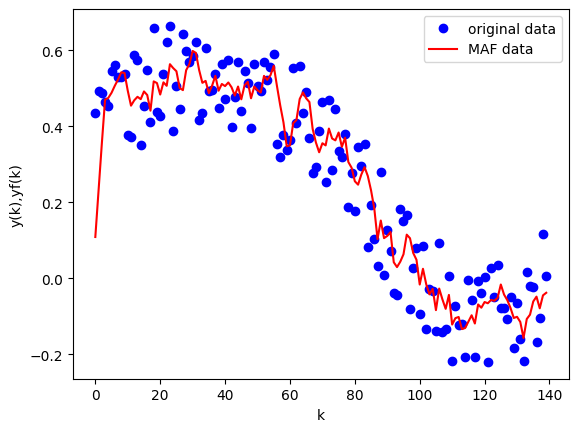

In [19]:
yf_vec = np.zeros((y_vec.shape))
for i in range(len(y_vec)):
    yf_vec[i] = rt_maf(y_vec[i,0]) # filter data as it arrives
plt.figure()
plt.plot(k_vec,y_vec,'bo',k_vec,yf_vec,'r-')
plt.xlabel("k")
plt.ylabel("y(k),yf(k)")
plt.legend(["original data","MAF data"])
plt.show()


### Exponentially-weighted moving average

An alternative algorithm that requires less computaiton is called an exponentially-weighted 
average filter. We'll abbreviate it as EWA. 
Define $v_k, \;\;k = 0,1, \ldots$ with  
$$
v_0 = 0 \tag{1}
$$
and next elements in the vector are computed from
$$
v_k = \beta v_{k-1} + (1-\beta)y_k \tag{2}
$$
We can estimate that $v_k$ is an average of $1/(1-\beta)$ data points 
For instance, $\beta = 0.5,0.9,0.98$ correspond to averages of 2,10,50 points, respectively.

ewa() can be written from (1),(2) as follows.


In [20]:
def ewa(y, beta):
    v_size = y.shape[0]
    v = np.zeros((v_size,1))
    for k in range(1,v_size):
        v[k,0] = beta*v[k-1,0] + (1-beta)*y[k,0]
    return v       

Apply the function to the synthesis data with $\beta = 0.5,0.9,0.98$ 

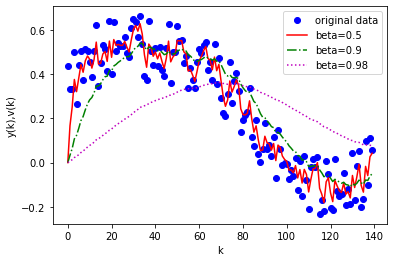

In [21]:
v_1 = ewa(y_vec,0.5)
v_2 = ewa(y_vec,0.9)
v_3 = ewa(y_vec,0.98)
plt.figure()
plt.plot(k_vec,y_vec,'bo',k_vec,v_1,'r-',k_vec,v_2,'g-.',k_vec,v_3,'m:')
plt.xlabel("k")
plt.ylabel("y(k),v(k)")
plt.legend(["original data","beta=0.5","beta=0.9","beta=0.98"])
plt.show()

### EWA with bias correction

We observe some discrepancy between the original and averaged data during the beginning. 
This happens becase we define $v_0 = 0$. Bias correction can be applied as follows. 

After computing $v_k$ in (1), normalize it by
$$
\tilde{v}_k = \frac{v_k}{1-\beta^k}  \tag{3}
$$


Noter that the denominator of term on the right of (3), $1-\beta^k$, is small at the beginning of 
algorithm. This helps compensate $v_k$ to become larger. As $k$ increases, $1-\beta^k$ approaches 1; i.e.,  
amount of compensation reduces.


Modify ewa() to ewa_bc() with scaling (3). 

In [22]:
def ewa_bc(y, beta):
    v_size = y.shape[0]
    v = np.zeros((v_size,1))
    v_tmp=0
    for k in range(1,v_size):
        v_tmp = beta*v_tmp + (1-beta)*y[k,0]
        v[k,0] = v_tmp/(1-beta**k)
    return v     

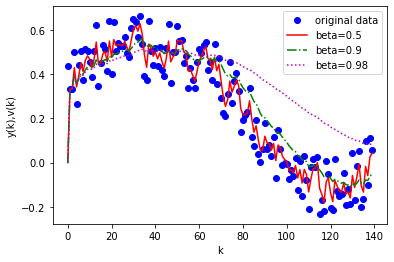

In [23]:
v_1_bc = ewa_bc(y_vec,0.5)
v_2_bc = ewa_bc(y_vec,0.9)
v_3_bc = ewa_bc(y_vec,0.98)
plt.figure()
plt.plot(k_vec,y_vec,'bo',k_vec,v_1_bc,'r-',k_vec,v_2_bc,'g-.',k_vec,v_3_bc,'m:')
plt.xlabel("k")
plt.ylabel("y(k),v(k)")
plt.legend(["original data","beta=0.5","beta=0.9","beta=0.98"])
plt.show()

**Exercise :** Can you implement a real-time version of EWA ?